In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Yenuganti Prathyusha 212223240187

In [14]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Enable inline plotting
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
# Set dataset path
root = '/content/drive/MyDrive/Data/train_test'



In [6]:
# Load datasets
train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

# Prepare DataLoaders
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)


In [7]:
# Class names
class_names = train_data.classes
print("Class Names:", class_names)
print(f'Training images: {len(train_data)}')
print(f'Testing images:  {len(test_data)}')


Class Names: ['Cat', 'Dog']
Training images: 88
Testing images:  20


In [8]:

# Load pretrained VGG19 model
VGG19model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:12<00:00, 46.5MB/s]


In [9]:
# Freeze all feature extraction layers
for param in VGG19model.features.parameters():
    param.requires_grad = False


In [10]:

# Set random seed for reproducibility
torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)  # Suitable for NLLLoss
)



In [11]:
# Print number of parameters in each layer (for reference)
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
2048
2


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

Yenuganti Prathyusha 212223240187

In [13]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
         # Print every 20 batches
        if b % 20 == 0:
            acc = trn_corr.item() * 100 / ((b + 1) * train_loader.batch_size)
            print(f"Epoch: {i+1}  Batch: {b+1}  Loss: {loss.item():.4f}  Accuracy: {acc:.2f}%")


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch: 1  Batch: 21  Loss: 0.0000  Accuracy: 92.86%
Epoch: 2  Batch: 21  Loss: 0.0000  Accuracy: 94.05%
Epoch: 3  Batch: 21  Loss: 0.0000  Accuracy: 95.24%

Duration: 373 seconds


In [15]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(19), tensor(20), tensor(20)]
Test accuracy: 100.000%


In [16]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

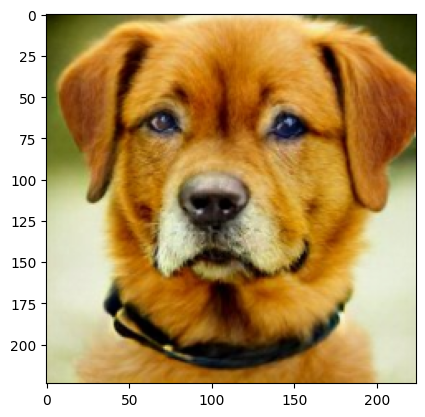

In [22]:
image_index = 11
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()



In [18]:
# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

'Dog'

Yenuganti Prathyusha 212223240187

In [23]:
torch.save(VGG19model.state_dict(),'Prathyusha Y.pt')

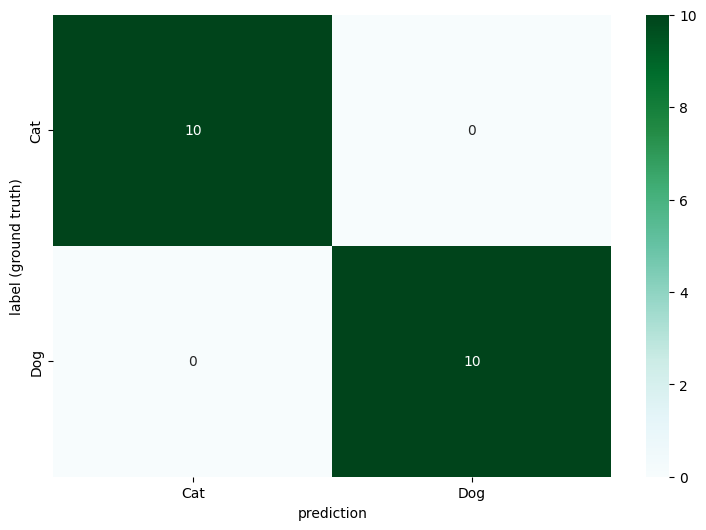

In [21]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()